In [1]:
# %load plot_template.py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from fbprophet import Prophet
import utlis

# disable the sdout logging of fbprophet
import logging 
logging.getLogger('fbprophet').setLevel(logging.ERROR)

In [3]:
# Replace PATH_TO_ROOT

import sys
PATH_TO_ROOT = 'C:/Users/walter/Desktop/git/Predicting City-Scale Daily Electricity Use and Daily Peak Demand'
sys.path.insert(0,PATH_TO_ROOT)

In [4]:
def generate_fig_path(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/results/fig/section3.3 time-series model/{}'.format(PATH_TO_ROOT, fig_name)

def generate_input_data_path(data_name):
    '''
    Generate the path to input data
    '''
    return '{}/results/data/{}.csv'.format(PATH_TO_ROOT, data_name)

def generate_result_data_path(data_name):
    '''
    Generate the path to save the result data
    '''
    return '{}/results/data/predict/{}.csv'.format(PATH_TO_ROOT, data_name)

In [5]:
def prophet_analysis(region):
    # read and clean the data
    data = pd.read_csv(generate_input_data_path(f'{region}_prophet'), index_col=0)
    data.index = pd.to_datetime(data.index)
    data = data.truncate(after='2019-07-01')
    data.rename(columns={'Electricity demand, daily sum, (GWh)': 'y'}, inplace=True)
    ## make sure data has not non:
    for field in data.columns:
        if data[field].isna().sum()>0:
            print(f'Missing entry for {field}: {data[data[field].isna()].index}')
            data[field] = data[field].interpolate()
        else:
            print(f'No missing values in the column {field}')
    data_train, data_test = utlis.prepare_data(data, train_ratio=0.75)

    m_noHoliday = Prophet(mcmc_samples=300,
                          holidays_prior_scale=0.05, \
                          changepoint_prior_scale=0.1, \
                          seasonality_mode='additive', \
                          yearly_seasonality=10, \
                          weekly_seasonality=3, \
                          daily_seasonality=False)
    m_noHoliday.add_regressor('HCDH', prior_scale=0.5, mode='additive')
    m_noHoliday.fit(data_train)

    future = m_noHoliday.make_future_dataframe(periods=len(data_test), freq='1D')
    futures = pd.concat([future, data[['HCDH']]], axis=1)
    futures.index = pd.to_datetime(futures.ds)

    forecast = m_noHoliday.predict(futures)

    f = m_noHoliday.plot_components(forecast)
    f.savefig(generate_fig_path(f'Figure 13_{region}'))

    data_plot = utlis.make_verif(forecast, data_train, data_test)[['y','yhat', 'train']]
    
    return data_plot

No missing values in the column y
No missing values in the column HCDH


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


No missing values in the column y
No missing values in the column HCDH


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


No missing values in the column y
No missing values in the column HCDH


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


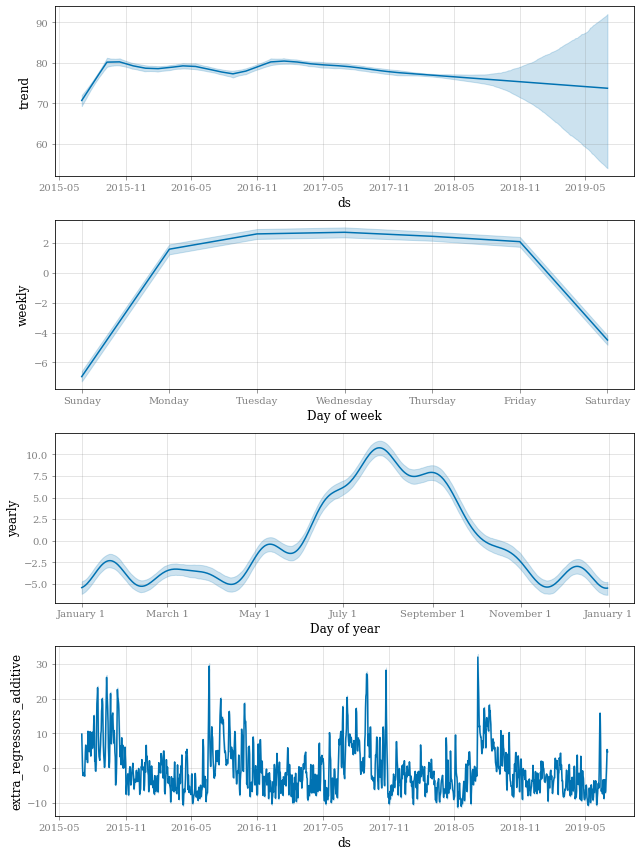

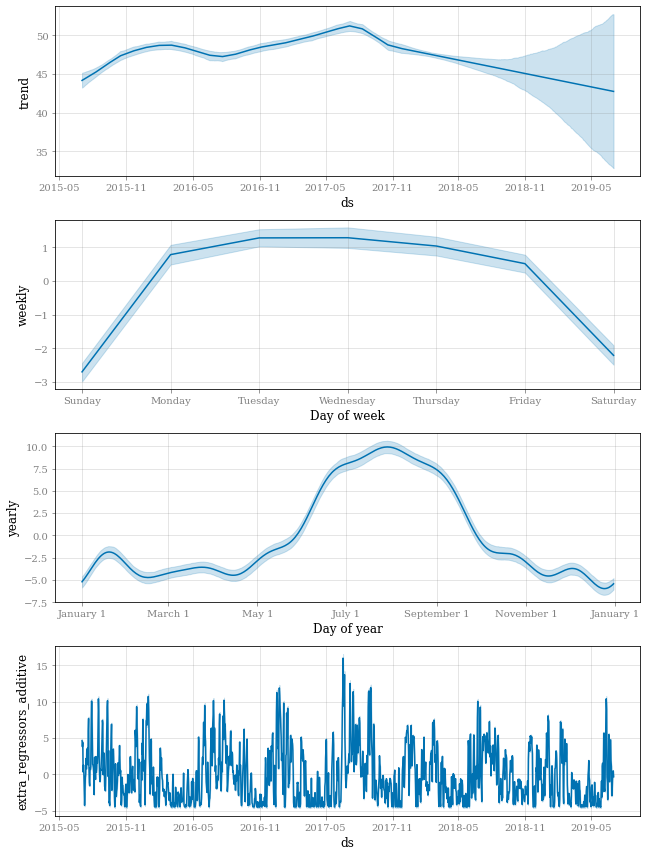

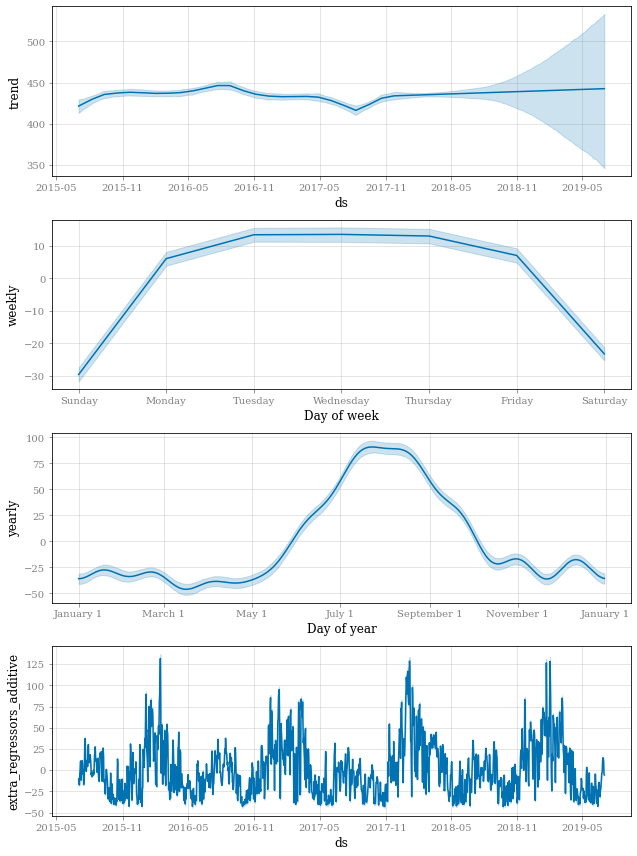

In [6]:
la_prophet = prophet_analysis('la')
sac_prophet = prophet_analysis('sac')
ny_prophet = prophet_analysis('ny')

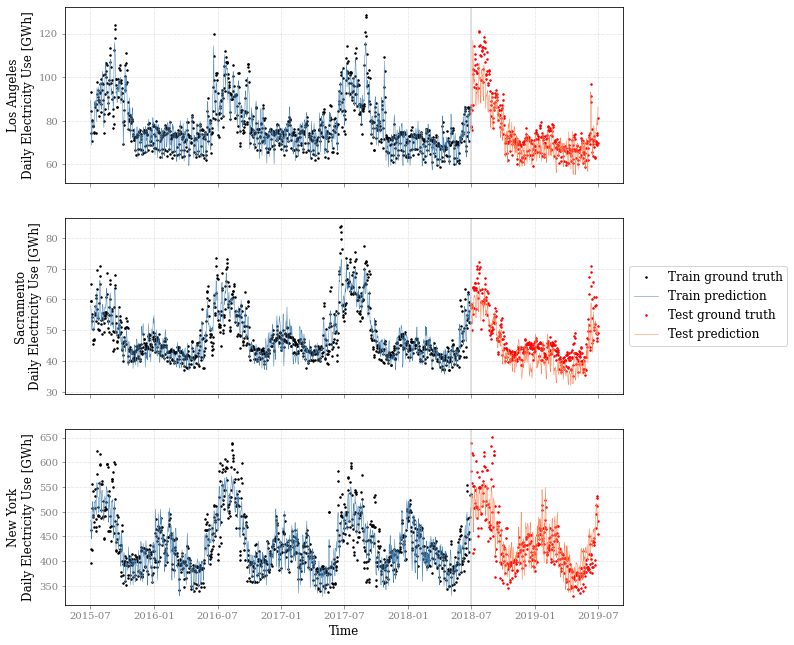

In [7]:
data_all = [la_prophet, sac_prophet, ny_prophet]
cities = ['Los Angeles', 'Sacramento', 'New York']
cities_shortName = ['la', 'sac', 'ny']

fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True)

for index in range(3):
    data = data_all[index]
    city = cities[index]
    city_shortName = cities_shortName[index]
    # save result for model comparison
    data.rename(columns={'yhat':'yhat_prophet'}, inplace=True)
    data.to_csv(generate_result_data_path(f'prophet_{city_shortName}'))
    
    train = data[data['train']]
    axes[index].plot(train.index, train.y, 'ko', markersize=1.5, label='Train ground truth')
    axes[index].plot(train.index, train.yhat_prophet, color='steelblue', lw=0.5, label='Train prediction')
    test = data[data['train'] == False]
    axes[index].plot(test.index, test.y, 'ro', markersize=1.5, label='Test ground truth')
    axes[index].plot(test.index, test.yhat_prophet, color='coral', lw=0.5, label='Test prediction')

    axes[index].axvline(data[data['train']].index[-1], color='0.8', alpha=0.7)
    axes[index].set_ylabel(f'{city}\nDaily Electricity Use [GWh]')
    axes[index].grid(ls=':', lw=0.5)

    # save result for model comparison
    data.rename(columns={'yhat':'yhat_prophet'}, inplace=True)
    data.to_csv(generate_result_data_path(f'prophet_{city_shortName}'))
    
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[2].set_xlabel('Time')

plt.savefig(generate_fig_path('Figure 12'))